In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


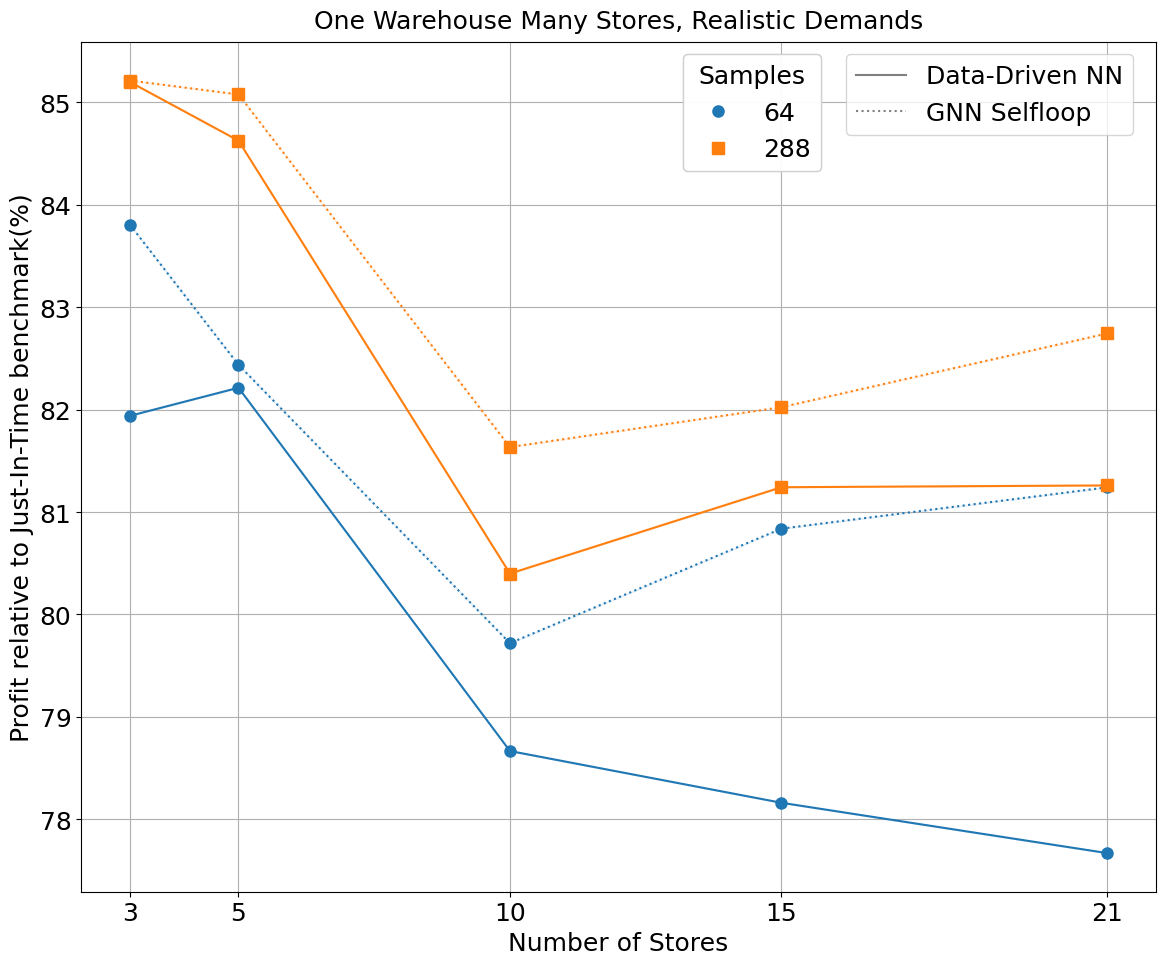

In [2]:
# Create vanilla results dataframe from the provided data
testset_name = "finals_real_one_warehouse_n_stores"

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme, line styles and markers
color_scheme = {
    64: "#1f77b4",     # Blue
    288: "#ff7f0e",    # Orange
}

marker_scheme = {
    64: "o",           # Circle
    288: "s",          # Square
}

linestyle_scheme = {
    "Data-Driven NN": "-",      # Solid
    "GNN": "--",               # Dashed
    #"GNN Bottleneck": "-.",     # Dotted
}

# Define paths for each architecture
architectures = {
    "Data-Driven NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/data_driven_net_real',
    "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_selfloop',
    #"GNN Bottleneck": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_bottleneck',
    "Just-In-Time": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/just_in_time_real',
}

# Define store counts to analyze
store_counts = [3, 5, 10, 15, 21]

# Base config for one warehouse with varying store counts
base_config = "one_warehouse_21_real_lost_demand"

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
sample_sizes = [64, 288]

dfs = []
jit_dfs = []

# Create dataframes for each architecture, store count and sample size
for arch_name, path in architectures.items():
    for n_stores in store_counts:
        if arch_name == "Just-In-Time":
            # For Just-In-Time, use matching sample sizes
            for sample_size in sample_sizes:
                jit_df = results_interpretor.make_table({1: path},
                    {'n_stores': [n_stores], 'train_dev_sample_and_batch_size': [sample_size]},
                    default_condition_setter, custom_data_filler,
                    sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25)
                if not jit_df.empty:
                    jit_df.insert(2, 'Architecture Class', arch_name)
                    jit_df.insert(1, 'hyperparam_name', arch_name)
                    jit_df['n_stores'] = n_stores
                    jit_df['train_dev_sample_and_batch_size'] = sample_size
                    jit_dfs.append(jit_df)
        else:
            # For other architectures, create dataframes for each sample size
            for sample_size in sample_sizes:
                df = results_interpretor.make_table({1: path},
                    {'train_dev_sample_and_batch_size': [sample_size],
                     'n_stores': [n_stores],
                     'test_n_samples': [sample_size]},
                    default_condition_setter, custom_data_filler,
                    sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25)
                if df.empty:
                    continue
                
                df.insert(2, 'Architecture Class', arch_name)
                df.insert(1, 'hyperparam_name', arch_name)
                df['train_dev_sample_and_batch_size'] = sample_size
                df['n_stores'] = n_stores
                dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)
jit_df = pd.concat(jit_dfs, ignore_index=True) if jit_dfs else pd.DataFrame()

# Find Just-In-Time loss for each store count and sample size
jit_losses = {}
for n_stores in store_counts:
    for sample_size in sample_sizes:
        jit_data = jit_df[(jit_df['n_stores'] == n_stores) & 
                          (jit_df['train_dev_sample_and_batch_size'] == sample_size)]
        if not jit_data.empty:
            jit_loss = jit_data['Test Loss'].min()
            jit_losses[(n_stores, sample_size)] = jit_loss

# Calculate loss ratio compared to Just-In-Time
stats_by_arch_sample_and_stores = {}
for n_stores in store_counts:
    stores_data = df[df['n_stores'] == n_stores].copy()
    
    if stores_data.empty:
        continue
    
    for sample_size in sample_sizes:
        if (n_stores, sample_size) not in jit_losses:
            continue
            
        jit_loss = jit_losses[(n_stores, sample_size)]
        
        sample_data = stores_data[stores_data['train_dev_sample_and_batch_size'] == sample_size].copy()
        if sample_data.empty:
            continue
            
        sample_data.loc[:, 'Loss Ratio'] = sample_data['Test Loss'] / jit_loss
        
        for arch in sample_data['Architecture Class'].unique():
            key = (arch, sample_size)
            if key not in stats_by_arch_sample_and_stores:
                stats_by_arch_sample_and_stores[key] = []
                
            arch_data = sample_data[sample_data['Architecture Class'] == arch]
            if not arch_data.empty:
                ratios = arch_data['Loss Ratio'].to_numpy()
                # Convert ratio to percentage (ratio - 1) * 100
                mean_percentage = np.mean(ratios * 100)
                std_percentage = np.std(ratios * 100)
                ci_95 = 1.96 * std_percentage / np.sqrt(len(ratios))
                stats_by_arch_sample_and_stores[key].append({
                    'n_stores': n_stores,
                    'mean_percentage': mean_percentage,
                    'ci_lower': mean_percentage - ci_95,
                    'ci_upper': mean_percentage + ci_95
                })

# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 10))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for (arch, sample_size), stats in stats_by_arch_sample_and_stores.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        # Sort by number of stores for proper x-axis ordering
        stats_df = stats_df.sort_values('n_stores')
        
        # Convert pandas series to numpy arrays before plotting
        n_stores_array = stats_df['n_stores'].to_numpy()
        mean_percentage_array = stats_df['mean_percentage'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(n_stores_array, mean_percentage_array,
                marker=marker_scheme[sample_size],
                color=color_scheme[sample_size],
                linestyle=linestyle_scheme[arch],
                markersize=8)
        
        plt.fill_between(n_stores_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[sample_size],
                        alpha=0.1)

# Create separate legend entries for architectures and sample sizes
arch_lines = [plt.Line2D([0], [0], color='gray', linestyle=linestyle_scheme[arch], label=arch) 
              for arch in linestyle_scheme.keys()]
sample_patches = [plt.Line2D([0], [0], color=color_scheme[size], marker=marker_scheme[size], 
                            linestyle='none', label=f'{size}', markersize=8)
                 for size in color_scheme.keys()]

plt.xlabel('Number of Stores', fontsize=FONTSIZE)
plt.ylabel('Profit relative to Just-In-Time benchmark(%)', fontsize=FONTSIZE)
plt.grid(True)

# Set x-ticks to show only number of stores
plt.xticks(store_counts, fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

# Create two separate legends
# Right legend for architectures
legend1 = plt.legend(handles=arch_lines, 
                    bbox_to_anchor=(0.99, 1),
                    loc='upper right', 
                    fontsize=FONTSIZE)
plt.gca().add_artist(legend1)

# Samples legend positioned to the left of legend1
legend2 = plt.legend(handles=sample_patches,
                    title='Samples',
                    bbox_to_anchor=(0.70, 1),
                    loc='upper right',
                    fontsize=FONTSIZE)
plt.gca().add_artist(legend2)
legend2.get_title().set_fontsize(FONTSIZE)

plt.title('One Warehouse Many Stores, Realistic Demands', fontsize=FONTSIZE, pad=10)

plt.tight_layout()
plt.show()